In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
print(f"데이테섯 정보 Rows : {tweet.shape[0]} Columns : {tweet.shape[1]}")
print(f"데이테섯 정보 Rows : {test.shape[0]} Columns : {test.shape[1]}")

데이테섯 정보 Rows : 7613 Columns : 5
데이테섯 정보 Rows : 3263 Columns : 4


### 클래스 분포 확인 


In [5]:
x=tweet.target.value_counts()
print(x)

0    4342
1    3271
Name: target, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

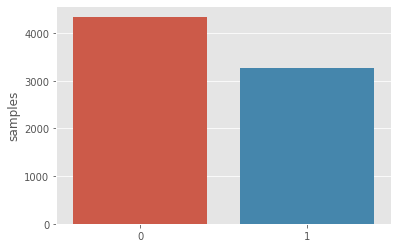

In [6]:
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

In [7]:
tweet[tweet['target']==1]['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

In [8]:
tweet[tweet['target']==1]['text'].str.len()

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 3271, dtype: int64

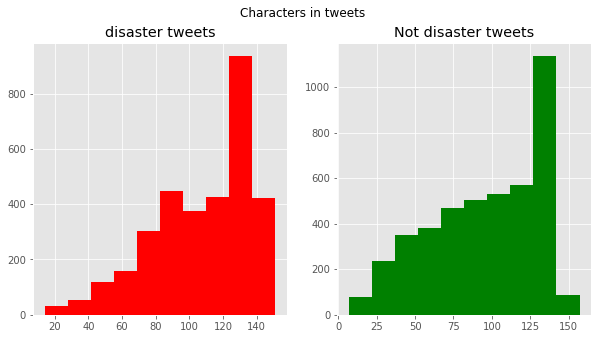

In [9]:
# 문장길
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(10, 5))

tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')

tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

In [10]:
tweet[tweet['target']==1]['text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 3271, dtype: object

In [11]:
tweet[tweet['target']==1]['text'].str.split()[0]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all']

In [12]:
len(tweet[tweet['target']==1]['text'].str.split()[0])

13

In [13]:
tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))

0       13
1        7
2       22
3        8
4       16
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: text, Length: 3271, dtype: int64

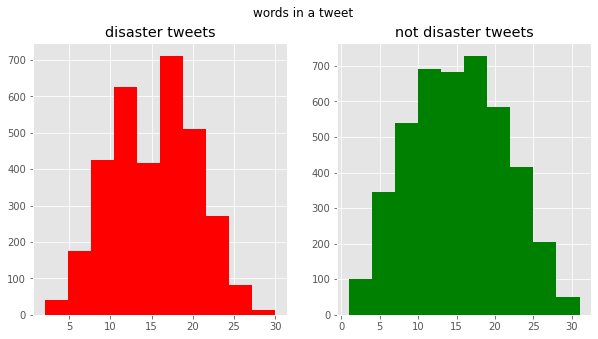

In [14]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x : len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')

tweet0_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x : len(x))
ax2.hist(tweet0_len, color='green')
ax2.set_title('not disaster tweets')

fig.suptitle('words in a tweet')
plt.show()

In [15]:
tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

0                [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                   [6, 4, 4, 2, 5, 5, 6]
2       [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                             [6, 6, 7, 10, 10, 6, 2, 10]
4       [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
                              ...                        
7608                   [3, 5, 6, 7, 1, 6, 8, 4, 6, 5, 22]
7609    [12, 12, 3, 3, 2, 7, 4, 5, 2, 10, 4, 2, 3, 8, ...
7610                            [5, 6, 8, 1, 2, 7, 7, 22]
7611    [6, 13, 5, 2, 6, 8, 4, 1, 3, 2, 6, 9, 6, 5, 8,...
7612            [3, 7, 4, 5, 5, 2, 8, 10, 8, 1, 3, 4, 22]
Name: text, Length: 3271, dtype: object

In [16]:
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
word

0                [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                   [6, 4, 4, 2, 5, 5, 6]
2       [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                             [6, 6, 7, 10, 10, 6, 2, 10]
4       [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
                              ...                        
7608                   [3, 5, 6, 7, 1, 6, 8, 4, 6, 5, 22]
7609    [12, 12, 3, 3, 2, 7, 4, 5, 2, 10, 4, 2, 3, 8, ...
7610                            [5, 6, 8, 1, 2, 7, 7, 22]
7611    [6, 13, 5, 2, 6, 8, 4, 1, 3, 2, 6, 9, 6, 5, 8,...
7612            [3, 7, 4, 5, 5, 2, 8, 10, 8, 1, 3, 4, 22]
Name: text, Length: 3271, dtype: object

In [17]:
word.map(lambda x : np.mean(x))

0       4.384615
1       4.571429
2       5.090909
3       7.125000
4       4.500000
          ...   
7608    6.636364
7609    5.300000
7610    7.250000
7611    6.263158
7612    6.307692
Name: text, Length: 3271, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

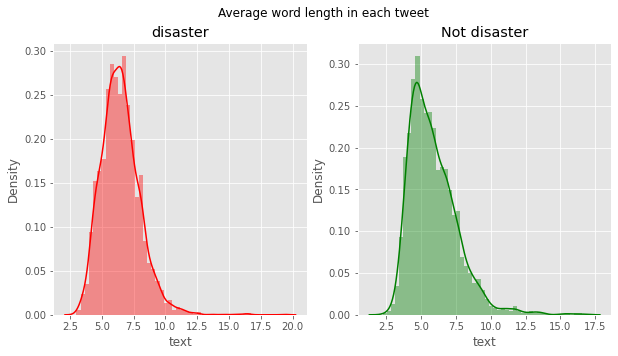

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [19]:
tweet[tweet['target']==1]['text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 3271, dtype: object

In [20]:
def create_corpus(target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [21]:
corpus=create_corpus(0)
dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1

In [22]:
dic

defaultdict(int,
            {'up': 167,
             'is': 512,
             'so': 190,
             'a': 1115,
             'this': 225,
             'that': 326,
             'in': 720,
             'my': 442,
             'you': 529,
             'to': 1099,
             'the': 1524,
             'out': 172,
             'for': 452,
             'me': 195,
             'but': 177,
             'they': 101,
             'will': 146,
             'these': 32,
             'on': 387,
             "you're": 49,
             'and': 840,
             'an': 120,
             'of': 834,
             'with': 349,
             'not': 162,
             'your': 201,
             'have': 219,
             'them': 47,
             'at': 212,
             'has': 131,
             'our': 51,
             'was': 205,
             'be': 268,
             'if': 107,
             'yours': 16,
             'by': 225,
             'about': 128,
             'their': 51,
             'what': 81,
        

In [23]:
top = sorted(dic.items(), key=lambda x : x[1], reverse=True)[:10]
# 불용어 
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

<BarContainer object of 10 artists>

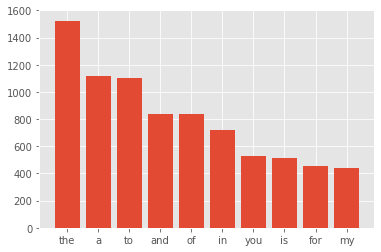

In [24]:
x,y=zip(*top)
plt.bar(x,y)

In [25]:
corpus=create_corpus(1)

dic=defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w]+=1
top=sorted(dic.items(), key=lambda x : x[1], reverse=True)[:10]
top

[('the', 1051),
 ('in', 1037),
 ('of', 888),
 ('a', 730),
 ('to', 706),
 ('and', 462),
 ('on', 386),
 ('for', 368),
 ('is', 302),
 ('at', 273)]

<BarContainer object of 10 artists>

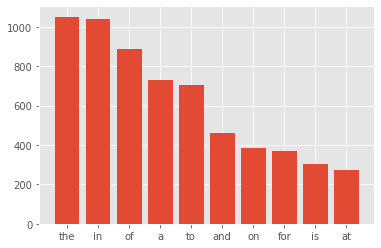

In [26]:
x,y=zip(*top)
plt.bar(x,y)

In [27]:
price_list = [32100, 32150, 32000, 32500]

for idx, x in reversed(list(enumerate(price_list))):
    print(f"{idx}번째 {x}")

3번째 32500
2번째 32000
1번째 32150
0번째 32100


In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

<BarContainer object of 18 artists>

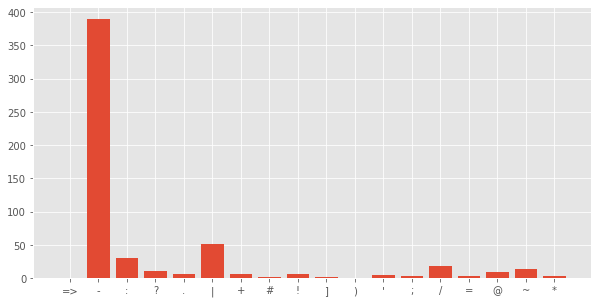

In [29]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [30]:
dic

defaultdict(int,
            {'=>': 1,
             '-': 389,
             ':': 31,
             '?': 11,
             '.': 7,
             '|': 51,
             '+': 7,
             '#': 2,
             '!': 6,
             ']': 2,
             ')': 1,
             "'": 5,
             ';': 3,
             '/': 18,
             '=': 4,
             '@': 9,
             '~': 14,
             '*': 3})

<BarContainer object of 20 artists>

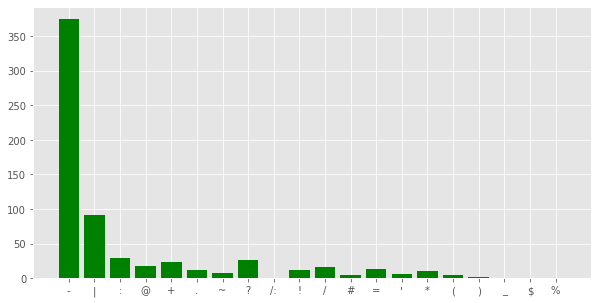

In [31]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')


In [32]:
counter=Counter(corpus)
counter

Counter({"What's": 12,
         'up': 167,
         'man?': 1,
         'I': 938,
         'love': 59,
         'fruits': 1,
         'Summer': 7,
         'is': 512,
         'lovely': 2,
         'My': 78,
         'car': 27,
         'so': 190,
         'fast': 8,
         'What': 36,
         'a': 1115,
         'goooooooaaaaaal!!!!!!': 1,
         'this': 225,
         'ridiculous....': 1,
         'London': 7,
         'cool': 12,
         ';)': 6,
         'Love': 22,
         'skiing': 1,
         'wonderful': 4,
         'day!': 3,
         'LOOOOOOL': 1,
         'No': 26,
         'way...I': 1,
         "can't": 56,
         'eat': 6,
         'that': 326,
         'shit': 29,
         'Was': 7,
         'in': 720,
         'NYC': 2,
         'last': 41,
         'week!': 1,
         'my': 442,
         'girlfriend': 4,
         'Cooool': 1,
         ':)': 13,
         'Do': 26,
         'you': 529,
         'like': 233,
         'pasta?': 1,
         'The': 295,
         'e

In [33]:
most = counter.most_common()

In [34]:
x=[]
y=[]

for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

In [35]:
x

['I', '-', 'The', 'like', '&amp;', "I'm", '??', 'get']

<AxesSubplot:>

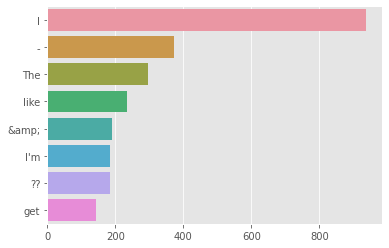

In [36]:
sns.barplot(x=y,y=x)

In [37]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

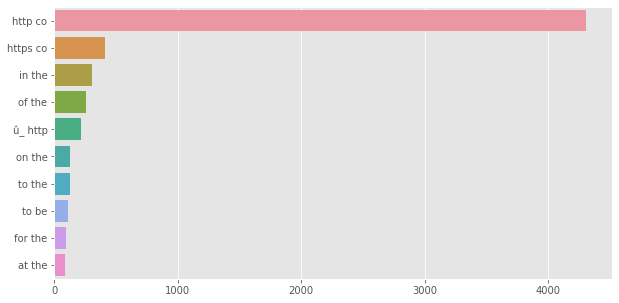

In [38]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

# Data Cleaning

In [39]:
df=pd.concat([tweet, test])
df.shape

(10876, 5)

In [40]:
# rm urls
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [41]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [42]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [43]:
re.compile(r'https?://\S+|www\.\S+').sub(r'', example)

'New competition launched :'

In [44]:
# html tag
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [45]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [46]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [47]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [48]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [49]:
str.maketrans?

In [50]:
str.maketrans('','',string.punctuation)

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

In [51]:
example.translate(str.maketrans('','',string.punctuation))

'I am a king'

In [52]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [53]:
df['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane My citya...
3260                    Green Line derailment in Chicago 
3261            MEG issues Hazardous Weather Outlook HWO 
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 10876, dtype: object

# 스펠링 체크

In [54]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.8 MB/s eta 0:00:00


In [55]:
from spellchecker import SpellChecker

In [56]:
spell = SpellChecker()

In [57]:
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [58]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]

In [59]:
for tweet in tqdm(df['text']):
    for word in word_tokenize(tweet):
        print(word)
    break

  0%|          | 0/10876 [00:00<?, ?it/s]

Our
Deeds
are
the
Reason
of
this
earthquake
May
ALLAH
Forgive
us
all


In [60]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [61]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7308.00it/s]


In [62]:
corpus

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['all',
  'residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'no',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['just',
  'got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hill', 'i', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['im', 'afraid', 'tornado', 'coming', 'area'],
 ['three', 'people

In [63]:
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        print(f"line = {line}")
        values=line.split()
        print(f"values = {values}")
        word=values[0]
        print(f"word = {word}")
        vectors=np.asarray(values[1:],'float32')
        print(f"vectors = {vectors}")
        embedding_dict[word]=vectors
        break
f.close()

line = the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

values = ['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087

In [64]:
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors

f.close()

In [65]:
corpus[:2]

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

In [66]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

In [67]:
tokenizer_obj.texts_to_sequences(corpus[0])

[[622], [5467], [738], [175], [80], [1805], [3529], [16]]

In [68]:
tm = tokenizer_obj.texts_to_sequences(corpus[1])
tm

[[96], [7], [138], [739], [7970], [7971], [1308]]

In [69]:
pad_sequences(tm,maxlen=MAX_LEN,truncating='post',padding='post')

array([[  96,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 138,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [70]:

sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [71]:
tokenizer_obj.word_index

{'i': 1,
 'the': 2,
 'like': 3,
 'amp': 4,
 'im': 5,
 'a': 6,
 'fire': 7,
 'get': 8,
 'new': 9,
 'via': 10,
 'news': 11,
 'people': 12,
 'one': 13,
 'in': 14,
 'dont': 15,
 'us': 16,
 'emergency': 17,
 'video': 18,
 'disaster': 19,
 'would': 20,
 'this': 21,
 'to': 22,
 'police': 23,
 'still': 24,
 'is': 25,
 'got': 26,
 'you': 27,
 'my': 28,
 'suicide': 29,
 'body': 30,
 'crash': 31,
 'burning': 32,
 'first': 33,
 'storm': 34,
 'rt': 35,
 'attack': 36,
 'time': 37,
 'back': 38,
 'know': 39,
 'california': 40,
 'fires': 41,
 'buildings': 42,
 'see': 43,
 'going': 44,
 'and': 45,
 'man': 46,
 'day': 47,
 'love': 48,
 'two': 49,
 'world': 50,
 'cant': 51,
 'bomb': 52,
 'if': 53,
 'nuclear': 54,
 'full': 55,
 'go': 56,
 'hiroshima': 57,
 'dead': 58,
 'youtube': 59,
 'watch': 60,
 'today': 61,
 'life': 62,
 'think': 63,
 'car': 64,
 'train': 65,
 'last': 66,
 'killed': 67,
 'it': 68,
 'accident': 69,
 'its': 70,
 'good': 71,
 'of': 72,
 'say': 73,
 'we': 74,
 'make': 75,
 'war': 76,
 'no':

In [72]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [73]:
num_words=len(word_index)+1

In [74]:
num_words

20343

In [75]:
len(np.zeros((num_words,100))[0])

100

In [76]:
embedding_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [77]:
embedding_dict.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [78]:
embedding_matrix=np.zeros((num_words,100))

In [79]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
for word, i  in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 388780.18it/s]


In [81]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.75546998,  1.03649998,  0.10213   , ..., -0.17502999,
        -0.13342001,  0.14582001],
       [ 0.03458   , -0.48119   ,  0.67565   , ..., -0.42317   ,
         0.49230999, -0.20338   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [82]:
model=Sequential()

2022-08-17 14:48:31.385512: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### SpatialDropout1D
Dropout(): 2D 입력을 정의합시다: [[1, 1, 1], [2, 2, 2]]. Dropout은 모든 요소를 ​​독립적으로 고려하며 [[1, 0, 1], [0, 2, 2]]와 같은 결과를 초래할 수 있습니다.

SpatialDropout1D(): 이 경우 결과는 [[1, 0, 1], [2, 0, 2]]와 같습니다. 두 번째 요소는 모든 채널에서 0으로 설정되었습니다.

In [83]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [85]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')

In [86]:
tweet.shape

(7613, 5)

In [87]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [88]:
tweet_pad.shape

(10876, 50)

In [89]:
train

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 396,  462, 1459, ...,    0,    0,    0],
       [  23, 1128, 3820, ...,    0,    0,    0],
       [   2,  147,   82, ...,    0,    0,    0]], dtype=int32)

In [90]:
tweet_pad

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 749,  478,  348, ...,    0,    0,    0],
       [4085,  536,  372, ...,    0,    0,    0],
       [3997, 2557, 1462, ...,    0,    0,    0]], dtype=int32)

In [91]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [92]:
history=model.fit(X_train,y_train,batch_size=4,epochs=3,validation_data=(X_test,y_test),verbose=2)

2022-08-17 14:48:32.897749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
1618/1618 - 117s - loss: 0.6812 - accuracy: 0.5797 - val_loss: 0.6160 - val_accuracy: 0.6708
Epoch 2/3
1618/1618 - 113s - loss: 0.5775 - accuracy: 0.7296 - val_loss: 0.5350 - val_accuracy: 0.7828
Epoch 3/3
1618/1618 - 112s - loss: 0.5429 - accuracy: 0.7506 - val_loss: 0.5098 - val_accuracy: 0.7925


In [93]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)